# This is the principal preeliminar notebook for data analysis and deployment

Created at 06/2024

This is a preeliminar notebook for my next project, it will serve as the foundation to develop a interactive web app for the analysis of anomalies within the stocks market. Curently, I've focused my analysis on the stocks of the major AI related comanies related to AI (Companies involved in AI developmento, implementation and hardware)

## Data mining using yfinance & pandas

To download the data I've used the yahoo finance API and it works with pandas library, and the data is taken from 1 year ago, for the following stocks: MSFT, GOOGL, TSLA, NVDA, TSM.

In [1]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

In [2]:
data = None
end_date = date.today().strftime('%Y-%m-%d')
start_date = (date.today() - timedelta(days=365)).strftime('%Y-%m-%d')

tickers = ['MSFT','GOOGL','TSLA','NVDA','TSM']

data = yf.download(tickers=tickers, group_by='Ticker', period='1y', progress=False)
data = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

C:\Users\guill\AppData\Local\Temp\ipykernel_17572\1522202378.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)


Here is the data of the stocks in a table format

In [3]:
stock_data = data.reset_index()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)
stock_data

Price,Ticker,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2023-07-17,GOOGL,125.940002,127.099998,124.199997,124.650002,124.507103,25716200
2023-07-17,MSFT,345.679993,346.989990,342.200012,345.730011,343.046478,20363900
2023-07-17,NVDA,46.289001,46.495998,45.262001,46.460999,46.447094,510488000
2023-07-17,TSLA,286.630005,292.230011,283.570007,290.380005,290.380005,131569600
2023-07-17,TSM,104.680000,105.029999,102.589996,104.790001,103.015312,10722600
...,...,...,...,...,...,...,...
2024-07-16,GOOGL,187.395004,188.679993,183.373596,183.919998,183.919998,17348912
2024-07-16,MSFT,454.220001,454.299988,446.660004,449.519989,449.519989,17038389
2024-07-16,NVDA,128.410004,129.039993,124.580002,126.360001,126.360001,211618990


## Exploratory Data Analysis

To have a nice analysis I will work with the market volume (number of total stocks in the market), and the adjusted close prices of each one in two graphs

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

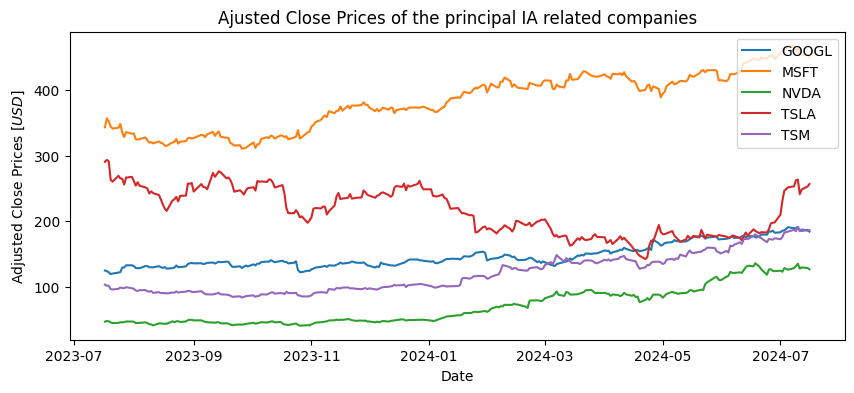

In [5]:
plt.figure(figsize=(10,4))

for tick in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker']==tick]
    plt.plot(subset.index, subset['Adj Close'], label=tick)

plt.title('Ajusted Close Prices of the principal IA related companies')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Prices [$USD$]')
plt.legend()
plt.show()

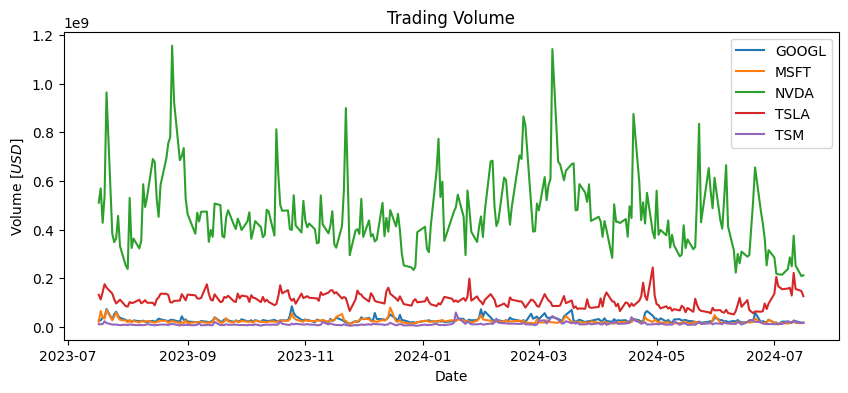

In [6]:
plt.figure(figsize=(10,4))

for tick in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker']==tick]
    plt.plot(subset.index, subset['Volume'], label=tick)

plt.title('Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

as we can see, there's too much more anomalies in the volume market than the other graph.

## ML model to detect market anomalies

When analyzing financial data, it’s crucial to identify anomalies that could impact our decisions. Two key aspects to consider are price movements and trading volumes.

1. Significant Price Movements: We observe whether adjusted closing prices deviate significantly from the typical range or trend of a stock. If a price is well above or below expectations, it could signal an anomaly.
Unusual Trading Volumes: We examine trading volumes to detect unusual activity. If volume is much higher or lower than usual, further investigation is warranted.

2. To identify these anomalies, we use the Z-score method. This method compares each data point to the mean and measures how many standard deviations away that point is. A common threshold for anomaly detection is a Z-score greater than 2 or less than -2, indicating that the data point is more than 2 standard deviations from the mean.

In summary, we calculate Z-scores for both adjusted closing prices and trading volumes of each stock. Any data point exceeding this threshold deserves special attention.

In [7]:
from scipy.stats import zscore

def detect_anomalies(df, column):
    df_copy = df.copy()
    df_copy['Z_score'] = zscore(df_copy[column])

    anomalies = df_copy[abs(df_copy['Z_score'])>2]
    return anomalies

anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

for tick in stock_data['Ticker'].unique():
    data_ticker = stock_data[stock_data['Ticker']==tick]

    adj_close_anomalies = detect_anomalies(data_ticker,'Adj Close')
    volume_anomalies = detect_anomalies(data_ticker, 'Volume')

    anomalies_adj_close = pd.concat([anomalies_adj_close,adj_close_anomalies])
    anomalies_volume = pd.concat([anomalies_volume,volume_anomalies])

anomalies_adj_close

Price,Ticker,Open,High,Low,Close,Adj Close,Volume,Z_score
Date,,,,,,,,
2024-06-25,GOOGL,179.619995,184.289993,179.419998,184.029999,184.029999,23235600,2.084858
2024-06-26,GOOGL,182.630005,184.509995,182.479996,183.880005,183.880005,19839000,2.076547
2024-06-27,GOOGL,184.179993,186.050003,184.020004,185.410004,185.410004,18848900,2.161330
2024-07-01,GOOGL,183.029999,183.880005,181.300003,182.990005,182.990005,16006100,2.027228
2024-07-02,GOOGL,182.050003,185.570007,181.559998,185.240005,185.240005,17372500,2.151910
2024-07-03,GOOGL,184.850006,186.089996,184.000000,185.820007,185.820007,10242100,2.184050
2024-07-05,GOOGL,185.860001,190.860001,185.800003,190.600006,190.600006,20967500,2.448929
2024-07-08,GOOGL,189.899994,190.169998,187.779999,189.029999,189.029999,21035900,2.361929
2024-07-09,GOOGL,190.309998,191.360001,188.720001,188.979996,188.979996,15121400,2.359158


### Now we need to plot the anomalies

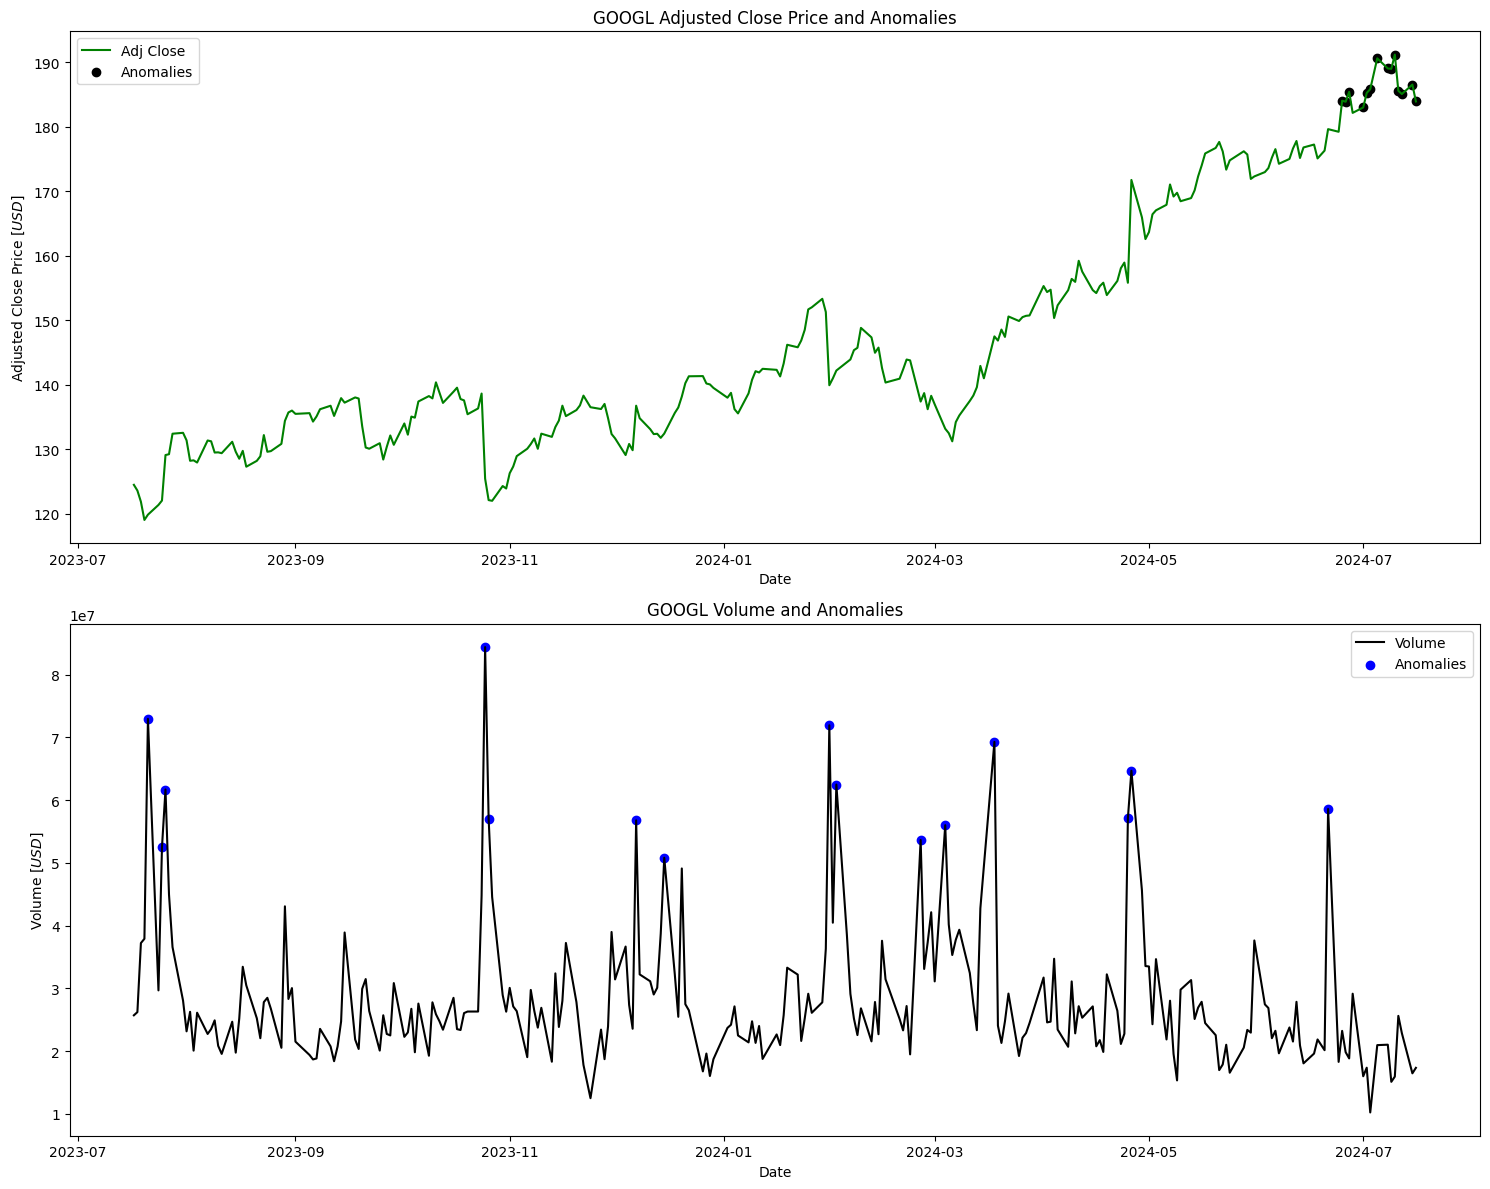

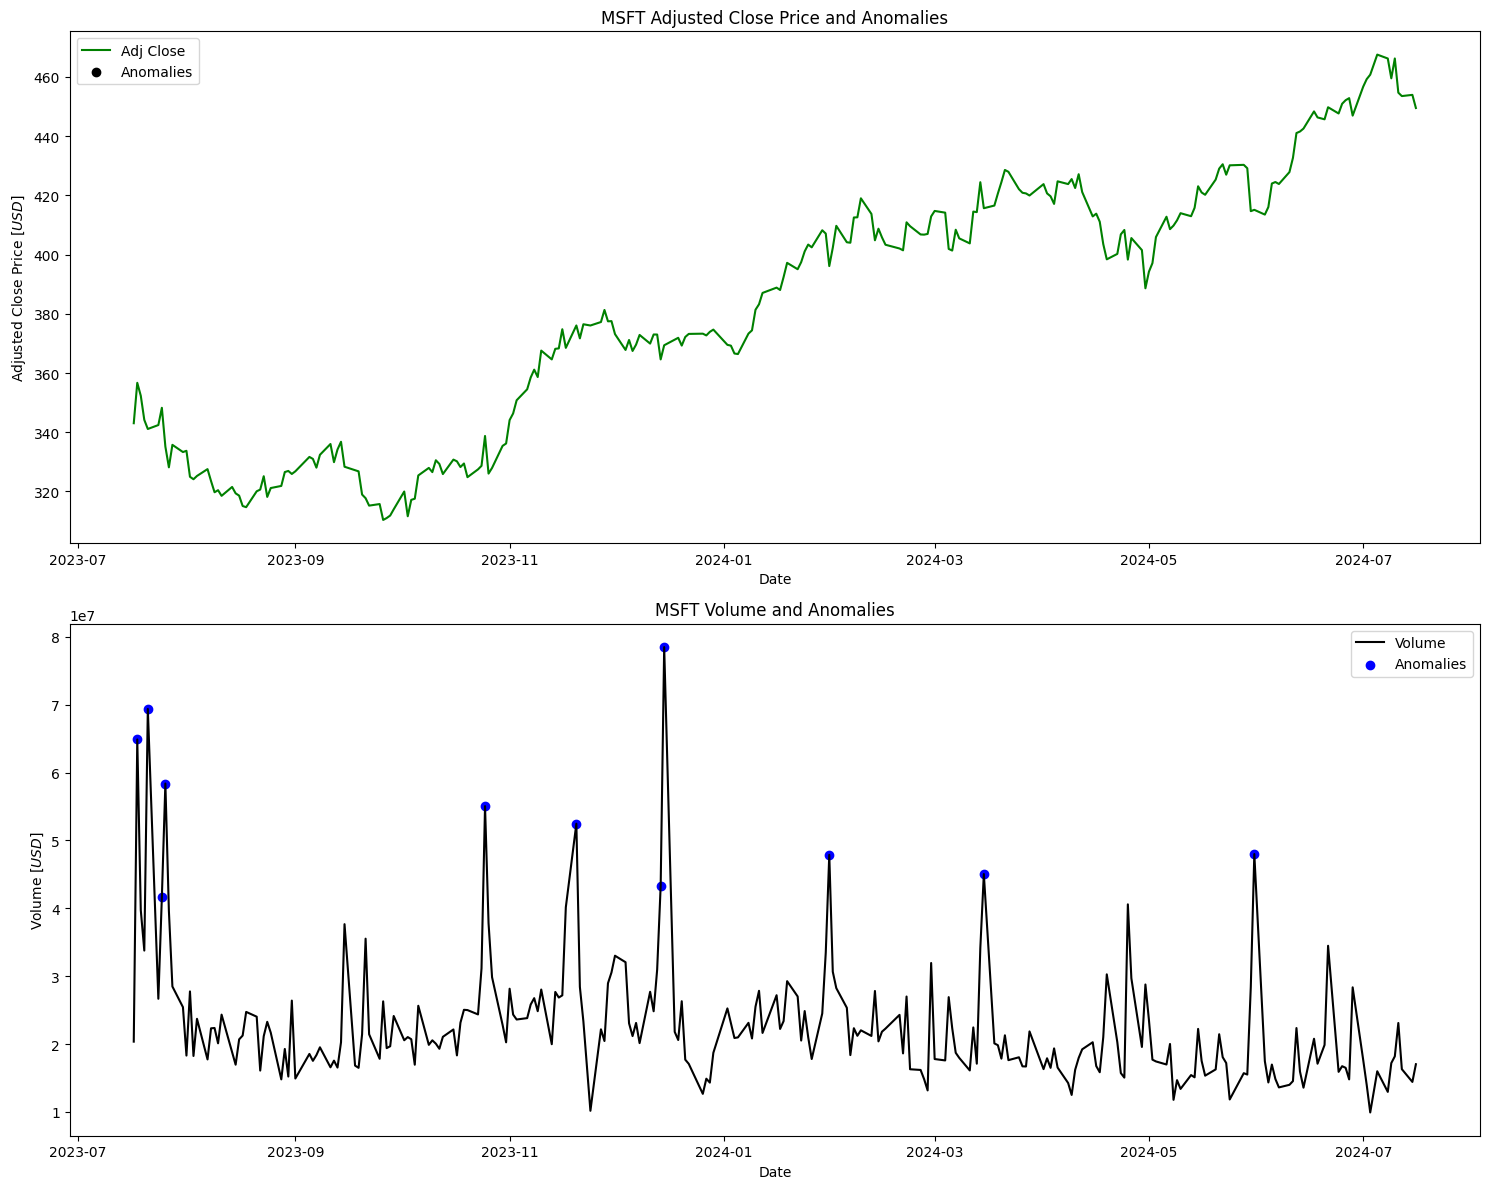

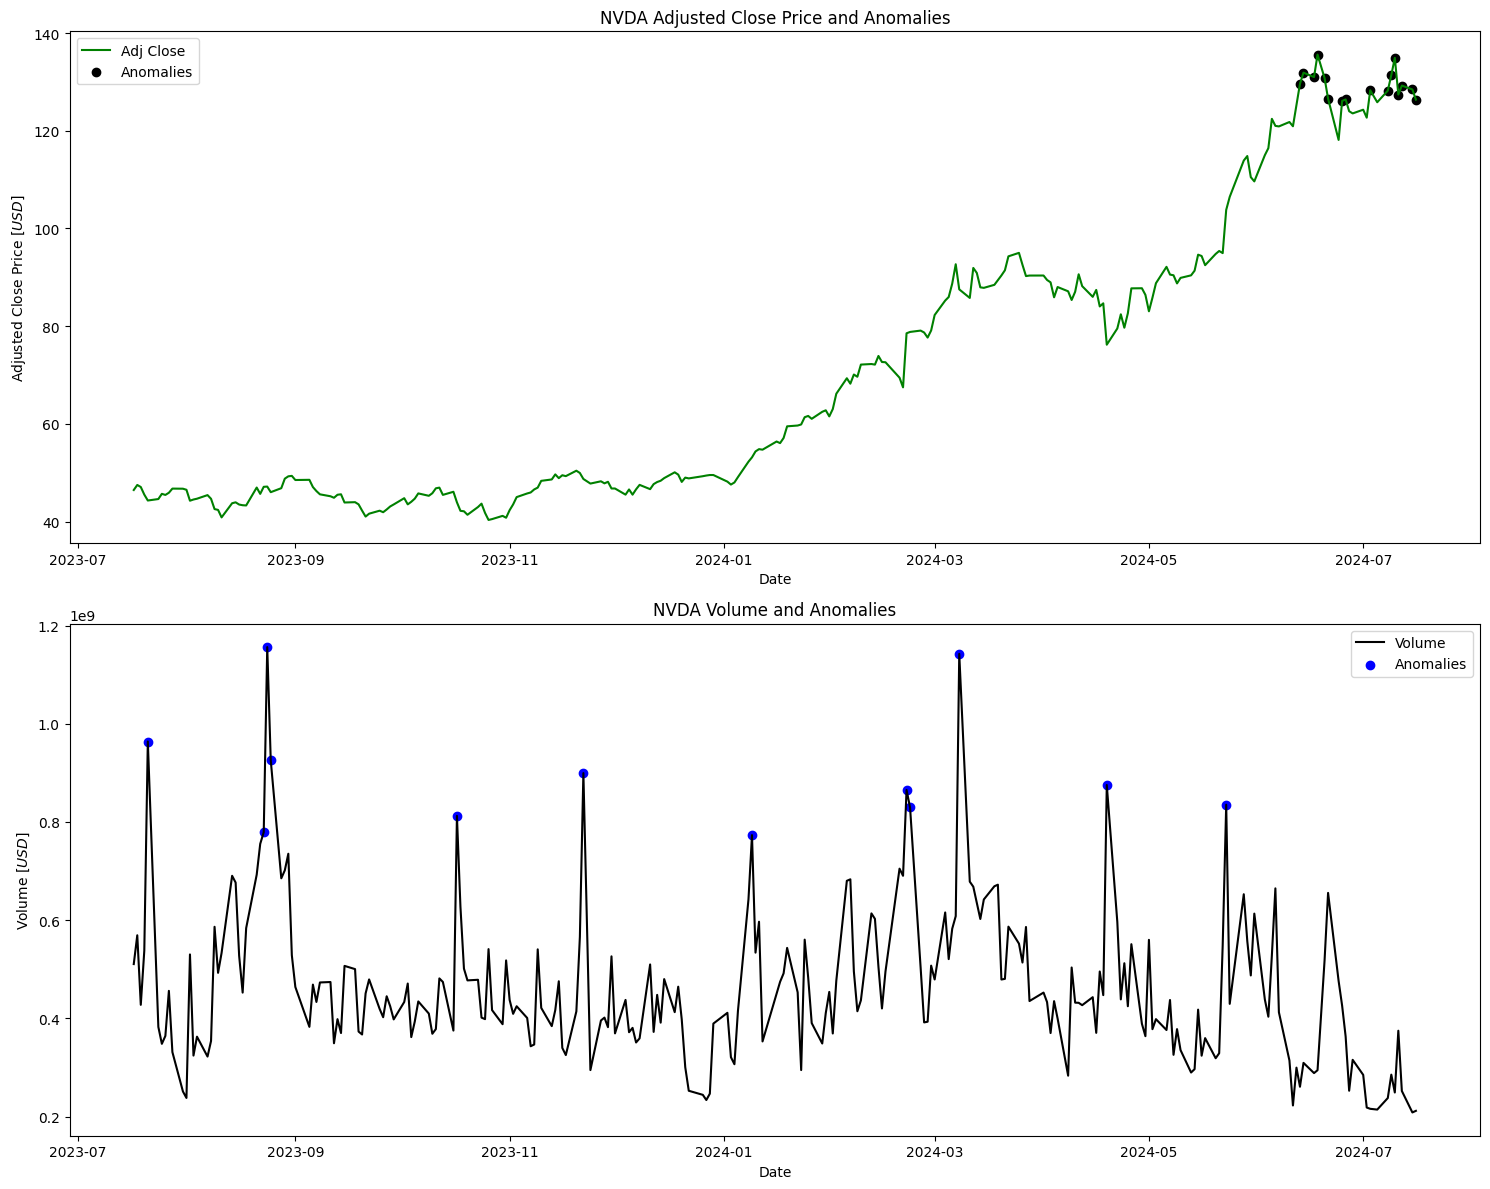

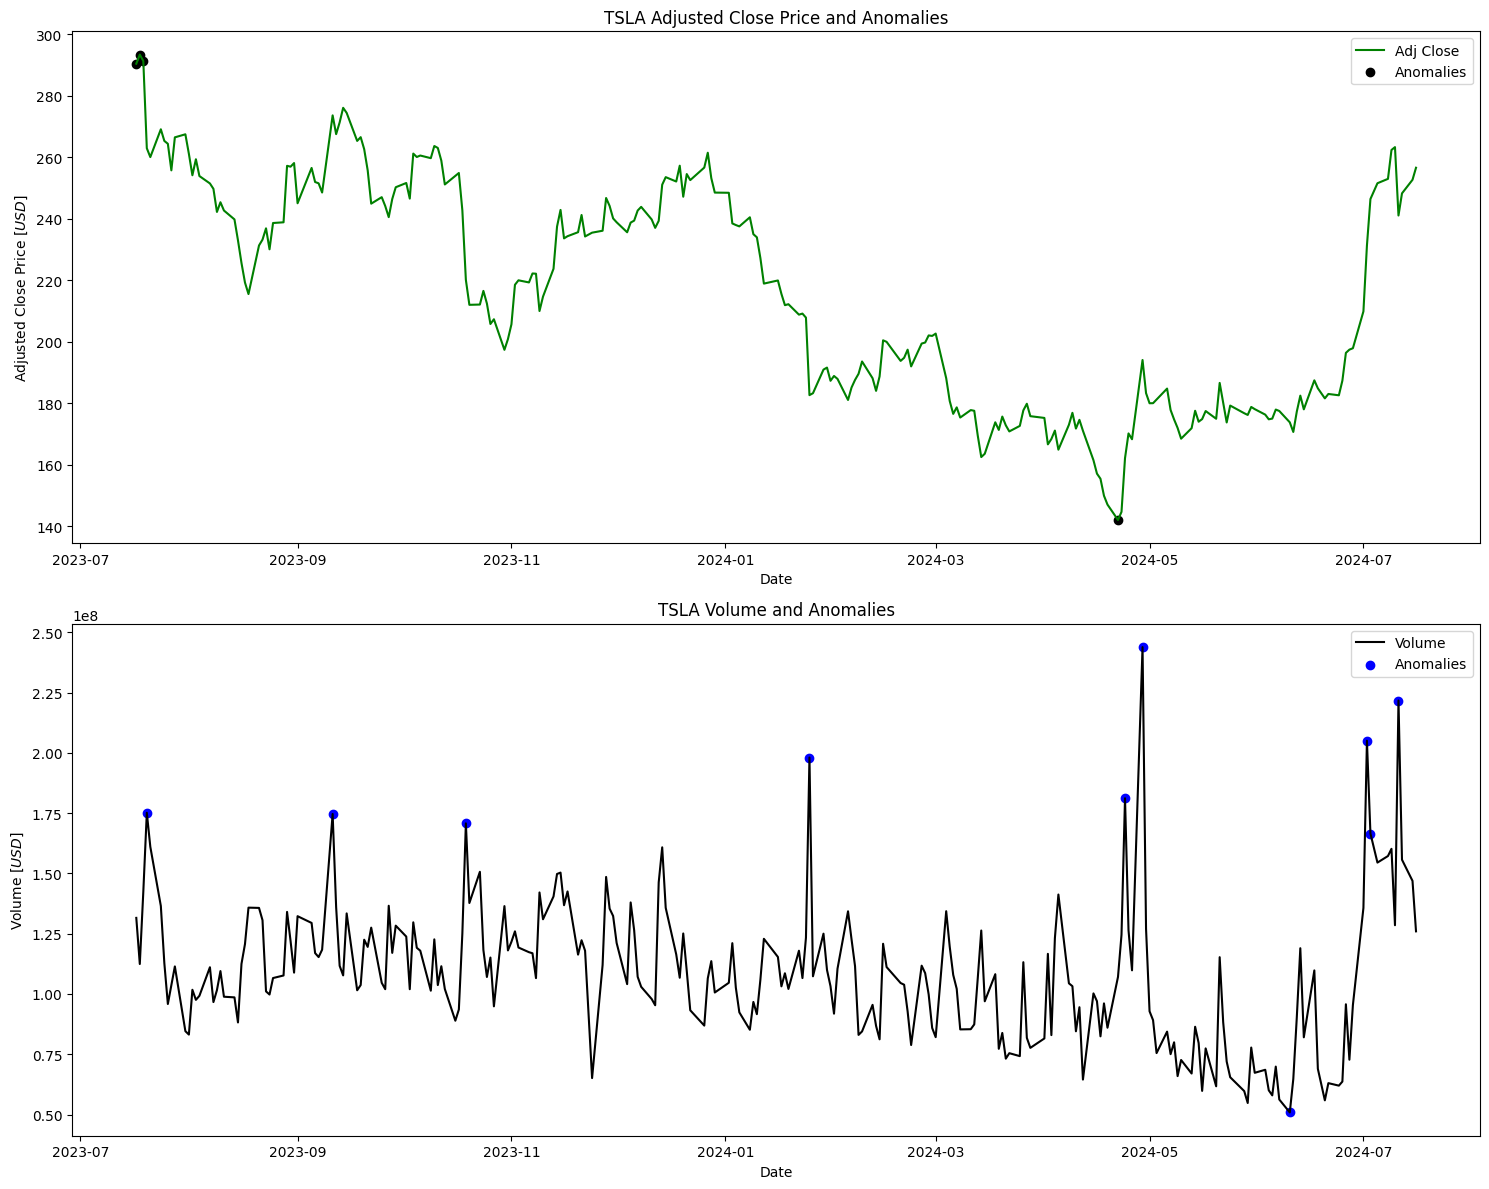

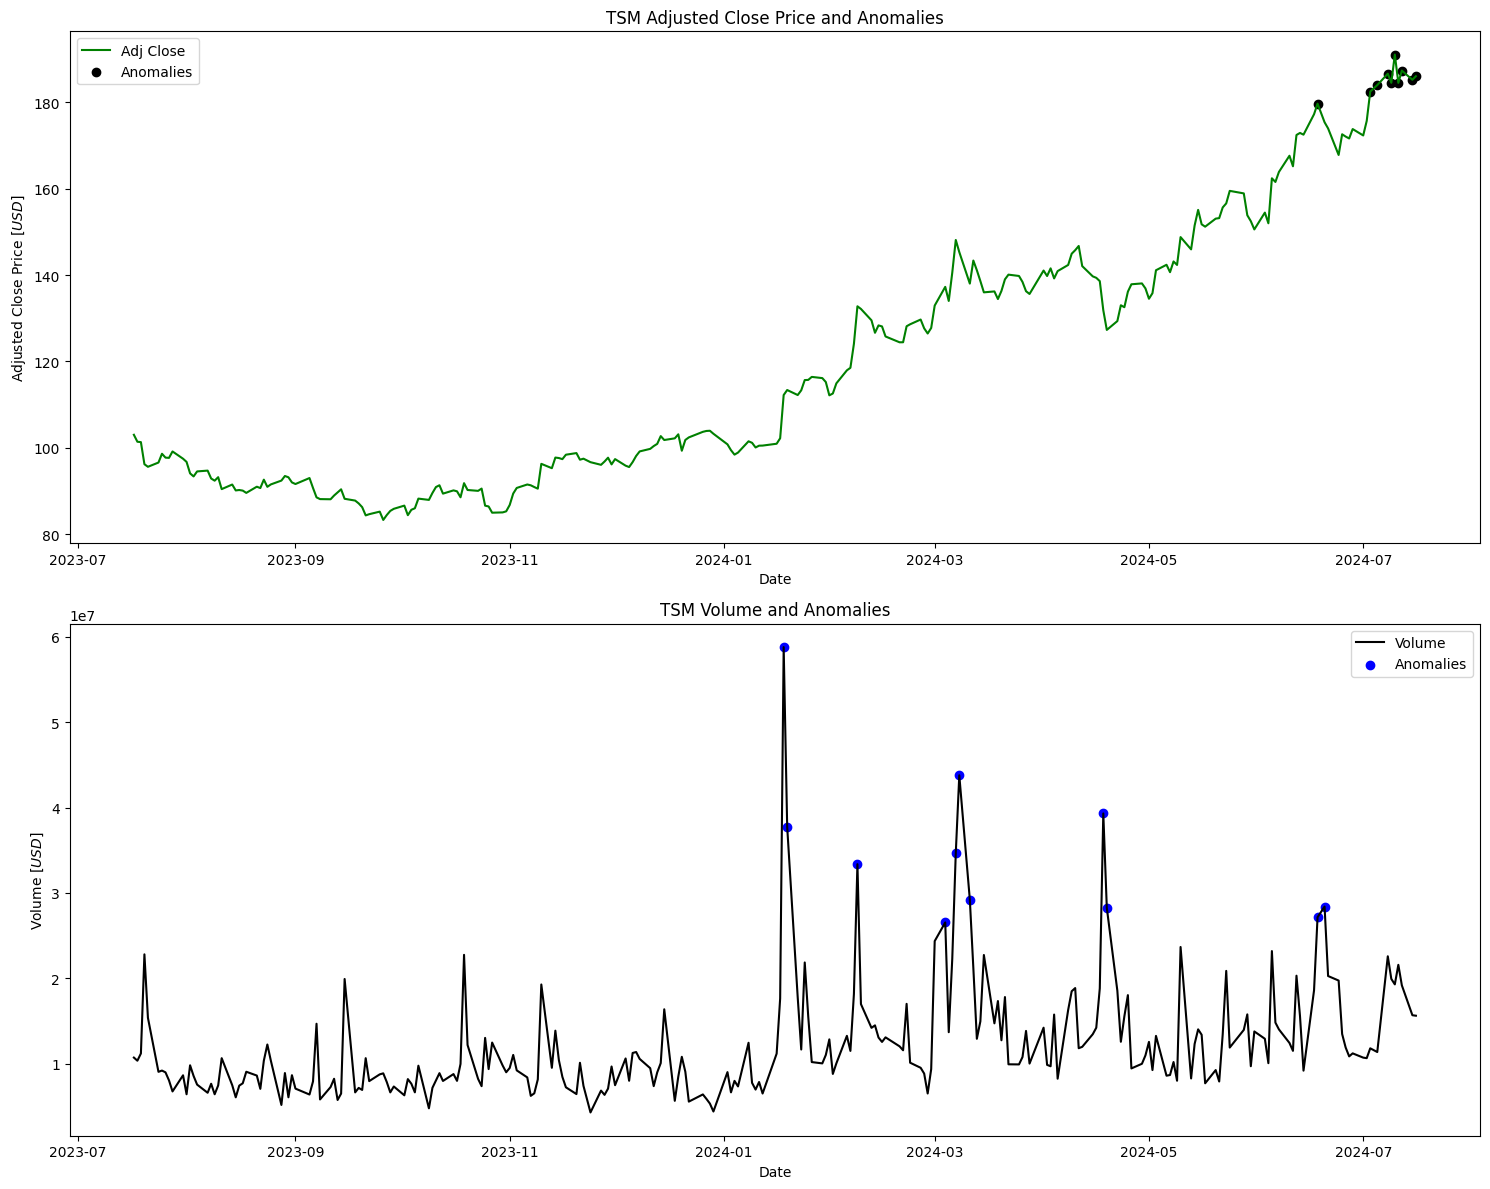

In [8]:
def plot_anomalies(ticker, anomalies_adj_close, anomalies_volume):
    # Filter tho main and anomalies data for ticker
    data_ticker = stock_data[stock_data['Ticker']==ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker']==ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,12))
    ax1.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color = 'green')
    ax1.scatter(adj_close_anomalies.index, adj_close_anomalies['Adj Close'], label = 'Anomalies', color = 'black')
    ax1.set_title(f'{ticker} Adjusted Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price [$USD$]')
    ax1.legend()


    ax2.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='black')
    ax2.scatter(volume_anomalies.index, volume_anomalies['Volume'], label ='Anomalies', color='Blue')
    ax2.set_title(f'{ticker} Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume [$USD$]')
    ax2.legend()

    plt.tight_layout()
    plt.show()

for tickers in stock_data['Ticker'].unique():
    plot_anomalies(tickers,anomalies_adj_close,anomalies_volume)

## Analizing correlations and risks

To evaluate the risk in the group as a function of other anomalies, is necesary to analyse these by a correlation analysis (correlation matrix)

In [9]:
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()
all_anomalies_adj_close['Adj Close Anomaly'] = 1

all_anomalies_volume = anomalies_volume[['Ticker']].copy()
all_anomalies_volume['Volume Anomaly'] = 1

adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index, columns='Ticker', fill_value=0, aggfunc='sum')
volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index, columns='Ticker', fill_value=0, aggfunc='sum')

adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

combined_anomalies = pd.concat([adj_close_pivot,volume_pivot], axis=1, keys=['Adj Close Anomaly', 'Volume Anomaly'])

correlation_matrix = combined_anomalies.corr()
correlation_matrix
#anomalies_adj_close

Adj Close Anomaly                                \
Ticker                               GOOGL      NVDA      TSLA       TSM   
                  Ticker                                                   
Adj Close Anomaly GOOGL           1.000000  0.119523 -0.529150  0.542857   
                  NVDA            0.119523  1.000000 -0.632456  0.418330   
                  TSLA           -0.529150 -0.632456  1.000000 -0.377964   
                  TSM             0.542857  0.418330 -0.377964  1.000000   
Volume Anomaly    GOOGL          -0.353553  0.258199 -0.166667 -0.353553   
                  MSFT           -0.353553 -0.645497  1.000000 -0.353553   
                  NVDA                 NaN       NaN       NaN       NaN   
                  TSLA            1.000000 -0.091287 -0.353553  0.416667   
                  TSM            -0.547723  0.400000 -0.258199  0.091287   

                         Volume Anomaly                                \
Ticker                            GOOGL      MSFT      NVDA      TSLA   
                  Ticker                                                
Adj Close Anomaly GOOGL       -0.353553 -0.353553       NaN  1.000000   
                  NVDA         0.258199 -0.645497       NaN -0.091287   
                  TSLA        -0.166667  1.000000       NaN -0.353553   
                  TSM         -0.353553 -0.353553       NaN  0.416667   
Volume Anomaly    GOOGL        1.000000  0.279394 -0.275293 -0.336336   
                  MSFT         0.279394  1.000000 -0.192663 -0.272441   
                  NVDA        -0.275293 -0.192663  1.000000 -0.288375   
                  TSLA        -0.336336 -0.272441 -0.288375  1.000000   
                  TSM         -0.251238 -0.289474 -0.078922 -0.272441   

                                    
Ticker                         TSM  
                  Ticker            
Adj Close Anomaly GOOGL  -0.547723  
                  NVDA    0.400000  
                  TSLA   -0.258199  
                  TSM     0.091287  
Volume Anomaly    GOOGL  -0.251238  
                  MSFT   -0.289474  
                  NVDA   -0.078922  
                  TSLA   -0.272441  
                  TSM     1.000000

Adj Close Anomaly:

1. The correlation between the adjusted closing price anomalies of GOOGL and NVDA is 0.76, suggesting a moderate positive relationship.

2. The correlation between the adjusted closing price anomalies of GOOGL and TSLA is -0.93, indicating a strong negative relationship.

3. The correlation between the adjusted closing price anomalies of TSLA and TSM is -0.96, also suggesting a strong negative relationship.

Volume Anomaly:

1. The correlation between the volume anomalies of GOOGL and MSFT is 0.16, indicating a weak positive relationship.

2. The correlation between the volume anomalies of TSLA and TSM is -0.60, suggesting a moderate negative relationship.

### Analyzing the risk of anomalies

We can aproach the risk of anomalies by:

1. Frecuency of anomalies
2. Magnitude of anomalies

In [10]:
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z_score'].apply(lambda x : abs(x).mean())
volume_risk = anomalies_volume.groupby('Ticker')['Z_score'].apply(lambda x: abs(x).mean())

total_risk = adj_close_risk + volume_risk

risk_rating = (total_risk - total_risk.min())/ (total_risk.max() - total_risk.min())
risk_rating

Ticker
GOOGL    0.513796
MSFT          NaN
NVDA     0.075795
TSLA     0.000000
TSM      1.000000
Name: Z_score, dtype: float64

Now as I see, TSM has the most riskly price of the ones, and TSLA has very low anomalies in the analysis, and MSFT has no detectable anomalies in the period analyzed, this is compared to the other ones